<h1> Quantitative Analysis </h1>

---

<h2> Preprocessing Steps </h2>

<h4>Step 1</h4>

Read data into Pandas dataframe and examine the data.

In [1]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

def load_json_to_df(path: Path) -> pd.DataFrame:
    """
    Takes a file path, opens the .json file at
    that position, and transforms it into a dataframe
    """
    with open(path, 'r') as f:
        json_data = json.load(f)
        return pd.DataFrame({
            "letter": json_data.values()
        }, index = json_data.keys())

DATA_DIR = Path.cwd() / "data"
KAGGLE_FILE_PATH = DATA_DIR / "ww1letters.json"
KAGGLE_METADATA_PATH = DATA_DIR / "index.csv"

kaggle_df = load_json_to_df(KAGGLE_FILE_PATH)
with open(KAGGLE_METADATA_PATH, 'r') as f:
    metadata_df = pd.read_csv(f)
    metadata_df.index = metadata_df["letter_key"]

kaggle_df = kaggle_df.join(
    metadata_df[["year", "language"]],
)
kaggle_df = kaggle_df[kaggle_df["year"].notna()].astype({"year": "int64"})
kaggle_df["language"] = kaggle_df["language"].fillna("english")

print(kaggle_df.head(), "\n")
print(kaggle_df.info())

                                                   letter  year language
arc71   Mercredi 29 septembre 1915\nMa chère Louisette...  1915   french
hl_02   Correspondance militaire adressée à monsieur J...  1914   french
hl_03a  Chère femme, mes deux gosses ainsi que toute m...  1914   french
hl_03b  Chers Mère et frère,\n\nTout ce que je vous re...  1914   french
hl_04   Aux armées le 27 mai 1916\n\n \nChers parents,...  1916   french 

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, arc71 to na_uk_40
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   letter    55 non-null     object
 1   year      55 non-null     int64 
 2   language  55 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.7+ KB
None


In [2]:
DEAREST_PATH = DATA_DIR / "400_letters.json"

dearest_df = load_json_to_df(DEAREST_PATH)

london_years = [1915] * 3 + [1916] * 6
france_years = [1917] * 77
missing_years = [1917] * 13
pow_years = [1918] * 174 + [1917] * 79
sheerness_years = [1919] * 15

dearest_df["year"] = london_years + france_years + missing_years + pow_years + sheerness_years
print(dearest_df.head(), "\n")
print(dearest_df.info())

                                                  letter  year
lo001  Dear Ginger, I have just returned from a holid...  1915
lo002  Zeppelins over London 4th Nov 1915 David to Gi...  1915
lo003  David Joins Army 28 Dec 1915 David to Ginger D...  1915
lo004  How Britain Prepared Ginger (Ethel)  to David ...  1916
lo005  1916 OTC Gidea Park David to Ginger (sister Et...  1916 

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, lo001 to sh015
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  367 non-null    object
 1   year    367 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB
None


<h4>Step 2</h4>

Retrieve English letters and apply tokenisation, lemmatisation, other steps?

How to deal with French letters?

We'll also explain more steps here.

credits to notebook

In [3]:
import nltk
from nltk.corpus import wordnet, stopwords
from collections import Counter

STEMMER = nltk.stem.WordNetLemmatizer()
un_to_wn_map = {"VERB" : wordnet.VERB,
                "NOUN" : wordnet.NOUN,
                "ADJ" : wordnet.ADJ,
                "ADV" : wordnet.ADV}

PUNCTUATIONS = {',', '.', ';', '?', '!', '&', '(', ')', '*', '-', '‘', '’', '“', '”', '[', ']', '…', '+'}
STOP = set(stopwords.words("english")).union(PUNCTUATIONS)

english_kaggle = kaggle_df["letter"][kaggle_df["language"] == "english"]
# print(english_kaggle)

def preprocess(df: pd.DataFrame, common_removed = 0.0) -> (list[str], Counter):
    """
    Takes a series of letters and preprocesses them
    by applying tokenisation, pos-tagging & lemmatisation.
    
    Removes the top <common_removed>% of most frequent
    words from the preprocessed results.
    
    Returns the preprocessed letters and a counter of
    word frequencies.
    """
    letters_preprocessed = []
    word_freqs = Counter()
    
    for letter in df:
        letter_tokens = nltk.tokenize.word_tokenize(letter.lower())
        letter_tagged = nltk.pos_tag(letter_tokens, tagset = "universal")
        letter_lemmas = []
        
        for (token, pos) in letter_tagged:
            token = token.strip('…')
            if token not in STOP:
                if pos in un_to_wn_map.keys():
                    lemma = STEMMER.lemmatize(token, pos = un_to_wn_map[pos])
                else:
                    lemma = STEMMER.lemmatize(token)
                
                letter_lemmas.append(lemma)
                word_freqs[lemma] += 1
        
        letters_preprocessed.append(' '.join(letter_lemmas))

    num_remove = int(common_removed * len(word_freqs))
    words_remove = set([
        item[0] for item in word_freqs.most_common(num_remove)
    ])

    # remove top words
    letters_preprocessed = [
        ' '.join([word for word in letter.split(' ')
                  if word not in words_remove])
        for letter in letters_preprocessed
    ]

    return letters_preprocessed

REMOVE = 0.02
english_kaggle_pp = preprocess(english_kaggle, REMOVE)
dearest_pp = preprocess(dearest_df["letter"], REMOVE)

<h4>Step 3</h4>

Replace the letters in the database.

In [4]:
english_data_df = kaggle_df[kaggle_df["language"] == "english"].copy()
english_data_df = english_data_df.drop(columns = ["language"])
english_data_df["letter"] = english_kaggle_pp

dearest_df["letter"] = dearest_pp

data_df = pd.concat([dearest_df, english_data_df], ignore_index = False)
data_df.index.name = "keys"

print(data_df.head(), "\n")
print(data_df.info())

data_df.to_csv(DATA_DIR / "preprocessed_letters.csv")

                                                  letter  year
keys                                                          
lo001  ginger return holiday brighton glorious chesha...  1915
lo002  zeppelin london 4th nov 1915 ginger 56 ramsden...  1915
lo003  join army 28 dec 1915 ginger dec 28th 1915 ram...  1915
lo004  britain prepared ginger somewhere u.s.a. somet...  1916
lo005  1916 otc gidea park ginger sister live usa cad...  1916 

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, lo001 to na_uk_40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  403 non-null    object
 1   year    403 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB
None


---

<h2>General Statistics</h2>

<h4>ugh</h4>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

DATA_DIR = Path.cwd() / "data"
REMOVE = 0.02
letters = pd.read_csv(DATA_DIR / "preprocessed_letters.csv")["letter"]

DATA_SIZE = len(letters)
size_measures = {
    "text size": [],
    "vocab size": [],
    "type-token ratio": []
}
total_freq = Counter()
    
for letter in letters:
    tokens = letter.split(' ')
    text_size = len(tokens)
    vocab_size = len(set(tokens))
    
    size_measures["text size"].append(text_size)
    size_measures["vocab size"].append(vocab_size)
    size_measures["type-token ratio"].append(round(vocab_size / text_size, 2))
    
    total_freq += Counter(letter.split(' '))

Number of letters:  403 

---

Average text size is 132.33

Highest text size is 430
CORRESPONDING LETTER:
>> zeppelin london 4th nov 1915 ginger 56 ramsden rd balham nov 4th 1915 ginger zeppelin fortunate enough view whole great many happen 9.30. earlier passing zep raid tonight notice report paper somewhere happen common heard boom boom boom gun test something often practice ground bomb throw clapham common almost immediately boom strike zep sky saw burst firing saw beauty behind tree beautiful sight large cigar shape bar silver float along shin light search light fine clear star shin moon pretty dark throw zep gun worth shell burst world star pop hit stood watch sight south east later 12 clock thoroughly amongst suppose return view aldgate large elongated star shell flash light shell near definitely remain minute appear search light hover around outside nearly others comparatively damage although loss life great drop bomb new within 100 yard chancery lane gray inn harry thick tale e

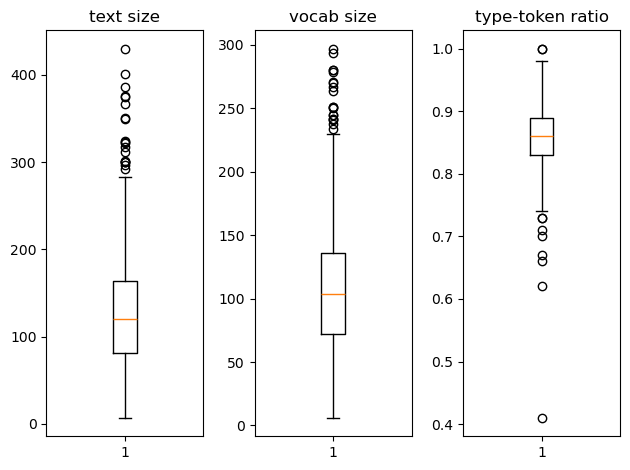

In [2]:
print("Number of letters: ", DATA_SIZE, "\n\n---")

fig, axes = plt.subplots(1, 3)

# i could make a box plot???
count = 0
for measure, vals in size_measures.items():
    axes[count].boxplot(vals)
    axes[count].title.set_text(measure)
    count += 1
    
    print(f"\nAverage {measure} is {round(sum(vals) / DATA_SIZE, 2)}")
    print(f"\nHighest {measure} is {max(vals)}")
    print("CORRESPONDING LETTER:\n>>", letters[vals.index(max(vals))])
    print(f"\nLowest {measure} is {min(vals)}")
    print("CORRESPONDING LETTER:\n>>", letters[vals.index(min(vals))])
    print("\n---")

fig.tight_layout()
plt.show()

<h4>OBSERVATIONS</h4>

Number of unique words 7737

30 most common words (after removing top 0.02%)
since:           129
receive:         125
month:           121
lot:             119
new:             119
many:            118
tea:             118
hour:            117
order:           117
present:         116
suppose:         115
use:             112
something:       111
sleep:           111
holiday:         110
usual:           110
however:         109
ever:            109
always:          109
whole:           108
road:            108
paper:           107
july:            107
balham:          106
thank:           105
bit:             104
till:            104
fire:            103
weather:         103
part:            101

30 least common words
b.e.f.:          1
j.:              1
lance:           1
3343:            1
non-fighting:    1
a.p.c:           1
ernie:           1
redford:         1
girl:            1
cowan:           1
morris:          1
f.r:             1
agreement:       1
them…kind:       1
thea

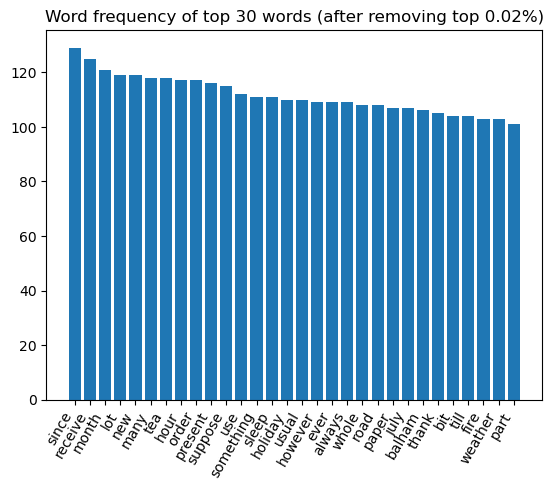

In [3]:
print("Number of unique words", len(total_freq))

NUM_COMMON = 30
top_common = total_freq.most_common(NUM_COMMON)

print(f"\n{NUM_COMMON} most common words (after removing top {REMOVE}%)")
for word, freq in top_common:
    print(f"{word}:{' ' * (16 - len(word))}{freq}")

print(f"\n{NUM_COMMON} least common words")
for word, freq in list(reversed(total_freq.most_common()))[:NUM_COMMON]:
    print(f"{word}:{' ' * (16 - len(word))}{freq}")

ax = plt.subplots()[1]
ax.bar([item[0] for item in top_common],
       [item[1] for item in top_common])
ax.set_title(f"Word frequency of top {NUM_COMMON} words (after removing top {REMOVE}%)")
plt.xticks(rotation = 60, ha = "right")
plt.show()

<h4>OBSERVATIONS</h4>